# Link prediction with GraphSAGE

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In this example, we use our implementation of the [GraphSAGE](http://snap.stanford.edu/graphsage/) algorithm to build a model that predicts citation links in the Cora dataset (see below). The problem is treated as a supervised link prediction problem on a homogeneous citation network with nodes representing papers (with attributes such as binary keyword indicators and categorical subject) and links corresponding to paper-paper citations. 

To address this problem, we build a model with the following architecture. First we build a two-layer GraphSAGE model that takes labeled node pairs (`citing-paper` -> `cited-paper`)  corresponding to possible citation links, and outputs a pair of node embeddings for the `citing-paper` and `cited-paper` nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. Thus obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

In [1]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Loading the CORA network data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)


We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into a train and test graphs using the EdgeSplitter class in `stellargraph.data`. We will use the train graph for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data.
Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [4]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now repeat this procedure to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [5]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Summary of G_train and G_test - note that they have the same set of nodes, only differing in their edge sets:

In [6]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4399

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4399]
        Weights: all 1 (default)


In [7]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4887

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4887]
        Weights: all 1 (default)


Next, we create the link generators for sampling and streaming train and test link examples to the model. The link generators essentially "map" pairs of nodes (`citing-paper`, `cited-paper`) to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with (`citing-paper`, `cited-paper`) head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [61]:
batch_size = 20
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE. Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model:

In [62]:
num_samples = [20, 10]

For training we create a generator on the `G_train` graph, and make an iterator over the training links using the generator's `flow()` method. The `shuffle=True` argument is given to the `flow` method to improve training.

In [63]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

At test time we use the `G_test` graph and don't specify the `shuffle` argument (it defaults to `False`).

In [64]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated (`citing-paper`, `cited-paper`) node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [103]:
def GraphSAGE_case_study(node_num):
    layer_sizes = [node_num, 20]
    graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
    )
# Build the model and expose input and output sockets of graphsage model
# for link prediction
    x_inp, x_out = graphsage.in_out_tensors()
#Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with ?link_classification in it), and passes it through a dense layer:
    prediction = link_classification(
        output_dim=1, output_act="relu", edge_embedding_method="ip"
    )(x_out)
#Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=["acc"],
    )
# Evaluate the initial (untrained) model on the train and test set:
    init_train_metrics = model.evaluate(train_flow)
    init_test_metrics = model.evaluate(test_flow)

    #print("\nTrain Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_train_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    #print("\nTest Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_test_metrics):
        print("\t{}: {:0.4f}".format(name, val))
# Train the model:
    history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)
# Plot the training history:
#sg.utils.plot_history(history)
# Evaluate the trained model on test citation links:
    train_metrics = model.evaluate(train_flow)
    test_metrics = model.evaluate(test_flow)

    #print("\nTrain Set Metrics of the trained model:")
    #for name, val in zip(model.metrics_names, train_metrics):
        #print("\t{}: {:0.4f}".format(name, val))

    #print("\nTest Set Metrics of the trained model:")
    #for name, val in zip(model.metrics_names, test_metrics):
        #print("\t{}: {:0.4f}".format(name, val))
    return train_metrics, test_metrics

In [104]:
nodes = [2, 4, 6, 8, 10, 15, 20]
output = []
for node_num in nodes:
    output.append(GraphSAGE_case_study(node_num))

link_classification: using 'ip' method to combine node embeddings into edge embeddings
55/55 [==============================] - 6s 113ms/step - loss: 1.1697 - acc: 0.5710
	loss: 1.1184
	acc: 0.5789
	loss: 1.1697
	acc: 0.5710
Epoch 1/20
49/49 - 15s - loss: 0.9033 - acc: 0.5564 - val_loss: 0.8689 - val_acc: 0.5793
Epoch 2/20
49/49 - 14s - loss: 0.7520 - acc: 0.6055 - val_loss: 0.7649 - val_acc: 0.6282
Epoch 3/20
49/49 - 13s - loss: 0.6764 - acc: 0.6629 - val_loss: 0.7378 - val_acc: 0.6393
Epoch 4/20
49/49 - 13s - loss: 0.6006 - acc: 0.6988 - val_loss: 0.7141 - val_acc: 0.6624
Epoch 5/20
49/49 - 13s - loss: 0.5667 - acc: 0.7398 - val_loss: 0.7211 - val_acc: 0.6734
Epoch 6/20
49/49 - 14s - loss: 0.5563 - acc: 0.7121 - val_loss: 0.7222 - val_acc: 0.6753
Epoch 7/20
49/49 - 13s - loss: 0.5106 - acc: 0.7510 - val_loss: 0.6857 - val_acc: 0.6946
Epoch 8/20
49/49 - 13s - loss: 0.5183 - acc: 0.7510 - val_loss: 0.7259 - val_acc: 0.6845
Epoch 9/20
49/49 - 13s - loss: 0.4833 - acc: 0.7756 - val_loss:

49/49 - 14s - loss: 0.2328 - acc: 0.9406 - val_loss: 0.5804 - val_acc: 0.7878
Epoch 14/20
49/49 - 13s - loss: 0.2361 - acc: 0.9314 - val_loss: 0.5870 - val_acc: 0.7915
Epoch 15/20
49/49 - 12s - loss: 0.2330 - acc: 0.9303 - val_loss: 0.6015 - val_acc: 0.7897
Epoch 16/20
49/49 - 13s - loss: 0.2176 - acc: 0.9385 - val_loss: 0.6163 - val_acc: 0.7952
Epoch 17/20
49/49 - 13s - loss: 0.2284 - acc: 0.9416 - val_loss: 0.5720 - val_acc: 0.7943
Epoch 18/20
49/49 - 13s - loss: 0.1932 - acc: 0.9529 - val_loss: 0.6162 - val_acc: 0.7998
Epoch 19/20
49/49 - 12s - loss: 0.1860 - acc: 0.9488 - val_loss: 0.6384 - val_acc: 0.7943
Epoch 20/20
49/49 - 12s - loss: 0.1672 - acc: 0.9600 - val_loss: 0.6274 - val_acc: 0.7980
55/55 [==============================] - 6s 117ms/step - loss: 0.6694 - acc: 0.7924
link_classification: using 'ip' method to combine node embeddings into edge embeddings
55/55 [==============================] - 6s 102ms/step - loss: 0.8279 - acc: 0.6107
	loss: 0.7634
	acc: 0.6004
	loss: 0.8

In [106]:
train_loss1 = []
train_acc1 = []
test_loss1 = []
test_acc1 = []
for metrics in output:
    train_loss1.append(metrics[0][0])
    train_acc1.append(1/metrics[0][1])
    test_loss1.append(metrics[1][0])
    test_acc1.append(1/metrics[1][1])

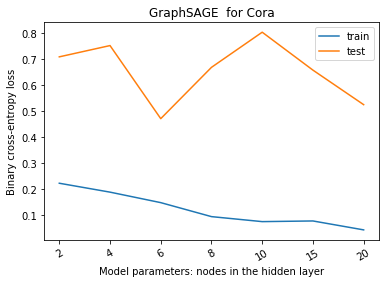

In [108]:
import matplotlib.pyplot as plt
plt.plot(range(len(nodes)), train_loss1, label = 'train')
plt.plot(range(len(nodes)), test_loss1, label = 'test')
plt.axis()
plt.xticks([i for i in range(len(nodes))], [i for i in nodes], rotation=30)
plt.xlabel('Model parameters: nodes in the hidden layer')
plt.ylabel('Binary cross-entropy loss')
plt.title('GraphSAGE  for Cora')
plt.legend();

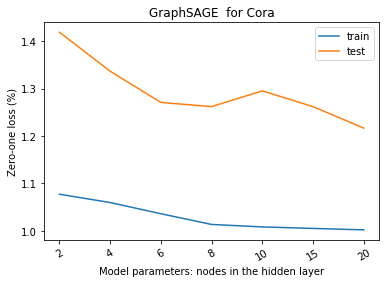

In [109]:
plt.plot(range(len(nodes)), train_acc1, label = 'train')
plt.plot(range(len(nodes)), test_acc1, label = 'test')
plt.axis()
plt.xticks([i for i in range(len(nodes))], [i for i in nodes], rotation=30)
plt.xlabel('Model parameters: nodes in the hidden layer')
plt.ylabel('Zero-one loss (%)')
plt.title('GraphSAGE  for Cora')
plt.legend();

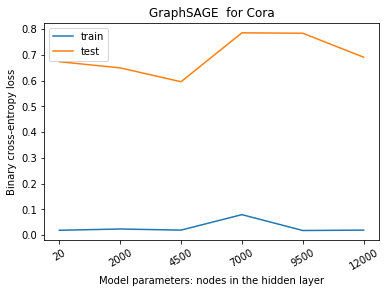

In [98]:
import matplotlib.pyplot as plt
plt.plot(range(len(output1)), train_loss1, label = 'train')
plt.plot(range(len(output1)), test_loss1, label = 'test')
plt.axis()
plt.xticks([i for i in range(len(output1))], [i for i in output1], rotation=30)
plt.xlabel('Model parameters: nodes in the hidden layer')
plt.ylabel('Binary cross-entropy loss')
plt.title('GraphSAGE  for Cora')
plt.legend();

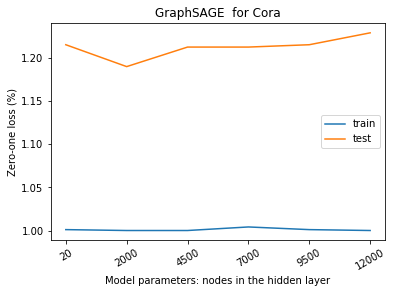

In [100]:
plt.plot(range(len(output1)), train_acc1, label = 'train')
plt.plot(range(len(output1)), test_acc1, label = 'test')
plt.axis()
plt.xticks([i for i in range(len(output1))], [i for i in output1], rotation=30)
plt.xlabel('Model parameters: nodes in the hidden layer')
plt.ylabel('Zero-one loss (%)')
plt.title('GraphSAGE  for Cora')
plt.legend();

In [66]:
nodes = [20, 5000, 10000, 20000, 25000, 30000, 40000, 50000, 60000]

In [67]:
output = []
for node_num in nodes:
    output.append(GraphSAGE_case_study(node_num))

link_classification: using 'ip' method to combine node embeddings into edge embeddings
55/55 [==============================] - 6s 105ms/step - loss: 0.6428 - acc: 0.6375
	loss: 0.6677
	acc: 0.6434
	loss: 0.6428
	acc: 0.6375
Epoch 1/20
49/49 - 13s - loss: 0.6814 - acc: 0.6055 - val_loss: 0.5946 - val_acc: 0.6522
Epoch 2/20
49/49 - 13s - loss: 0.5580 - acc: 0.7398 - val_loss: 0.4742 - val_acc: 0.7768
Epoch 3/20
49/49 - 12s - loss: 0.4244 - acc: 0.8391 - val_loss: 0.4400 - val_acc: 0.7998
Epoch 4/20
49/49 - 13s - loss: 0.3729 - acc: 0.8863 - val_loss: 0.4091 - val_acc: 0.8173
Epoch 5/20
49/49 - 13s - loss: 0.3071 - acc: 0.9027 - val_loss: 0.3778 - val_acc: 0.8275
Epoch 6/20
49/49 - 14s - loss: 0.2799 - acc: 0.9170 - val_loss: 0.4135 - val_acc: 0.8303
Epoch 7/20
49/49 - 13s - loss: 0.2449 - acc: 0.9334 - val_loss: 0.4030 - val_acc: 0.8386
Epoch 8/20
49/49 - 13s - loss: 0.2289 - acc: 0.9600 - val_loss: 0.4113 - val_acc: 0.8506
Epoch 9/20
49/49 - 13s - loss: 0.2113 - acc: 0.9693 - val_loss:

Epoch 13/20
49/49 - 13s - loss: 0.0456 - acc: 0.9980 - val_loss: 0.6457 - val_acc: 0.8275
Epoch 14/20
49/49 - 13s - loss: 0.0430 - acc: 0.9969 - val_loss: 0.5898 - val_acc: 0.8395
Epoch 15/20
49/49 - 13s - loss: 0.0394 - acc: 0.9990 - val_loss: 0.6185 - val_acc: 0.8367
Epoch 16/20
49/49 - 13s - loss: 0.0361 - acc: 0.9969 - val_loss: 0.6111 - val_acc: 0.8284
Epoch 17/20
49/49 - 13s - loss: 0.0326 - acc: 0.9980 - val_loss: 0.6418 - val_acc: 0.8220
Epoch 18/20
49/49 - 13s - loss: 0.0340 - acc: 0.9990 - val_loss: 0.6522 - val_acc: 0.8312
Epoch 19/20
49/49 - 13s - loss: 0.0338 - acc: 0.9980 - val_loss: 0.6617 - val_acc: 0.8284
Epoch 20/20
49/49 - 13s - loss: 0.0315 - acc: 0.9990 - val_loss: 0.6734 - val_acc: 0.8220
55/55 [==============================] - 6s 101ms/step - loss: 0.6312 - acc: 0.8312
link_classification: using 'ip' method to combine node embeddings into edge embeddings
55/55 [==============================] - 6s 101ms/step - loss: 0.5851 - acc: 0.7122
	loss: 0.5997
	acc: 0.674

49/49 - 14s - loss: 0.4670 - acc: 0.7623 - val_loss: 0.5117 - val_acc: 0.7565
Epoch 4/20
49/49 - 14s - loss: 0.3581 - acc: 0.8730 - val_loss: 0.4573 - val_acc: 0.8155
Epoch 5/20
49/49 - 15s - loss: 0.3057 - acc: 0.9068 - val_loss: 0.4113 - val_acc: 0.8339
Epoch 6/20
49/49 - 14s - loss: 0.2602 - acc: 0.9180 - val_loss: 0.4490 - val_acc: 0.8321
Epoch 7/20
49/49 - 15s - loss: 0.2342 - acc: 0.9416 - val_loss: 0.4397 - val_acc: 0.8330
Epoch 8/20
49/49 - 14s - loss: 0.2048 - acc: 0.9539 - val_loss: 0.4539 - val_acc: 0.8349
Epoch 9/20
49/49 - 14s - loss: 0.1736 - acc: 0.9539 - val_loss: 0.4555 - val_acc: 0.8376
Epoch 10/20
49/49 - 14s - loss: 0.1542 - acc: 0.9641 - val_loss: 0.4595 - val_acc: 0.8321
Epoch 11/20
49/49 - 15s - loss: 0.1419 - acc: 0.9703 - val_loss: 0.4577 - val_acc: 0.8220
Epoch 12/20
49/49 - 14s - loss: 0.1313 - acc: 0.9703 - val_loss: 0.4605 - val_acc: 0.8266
Epoch 13/20
49/49 - 14s - loss: 0.1108 - acc: 0.9836 - val_loss: 0.4986 - val_acc: 0.8229
Epoch 14/20
49/49 - 14s - lo

In [76]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for metrics in output:
    train_loss.append(metrics[0][0])
    train_acc.append(1/metrics[0][1])
    test_loss.append(metrics[1][0])
    test_acc.append(1/metrics[1][1])

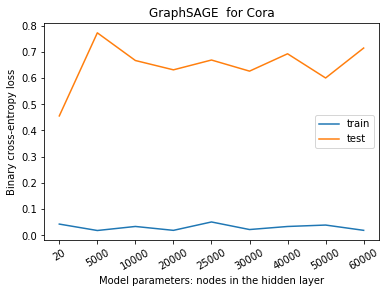

In [77]:
import matplotlib.pyplot as plt
plt.plot(range(len(nodes)), train_loss, label = 'train')
plt.plot(range(len(nodes)), test_loss, label = 'test')
plt.axis()
plt.xticks([i for i in range(len(nodes))], [i for i in nodes], rotation=30)
plt.xlabel('Model parameters: nodes in the hidden layer')
plt.ylabel('Binary cross-entropy loss')
plt.title('GraphSAGE  for Cora')
plt.legend();

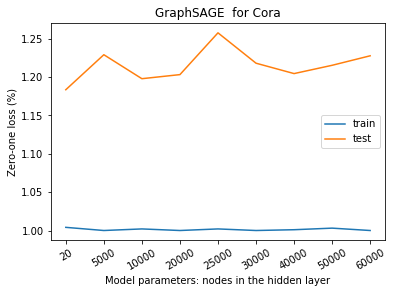

In [80]:
plt.plot(range(len(nodes)), train_acc, label = 'train')
plt.plot(range(len(nodes)), test_acc, label = 'test')
plt.axis()
plt.xticks([i for i in range(len(nodes))], [i for i in nodes], rotation=30)
plt.xlabel('Model parameters: nodes in the hidden layer')
plt.ylabel('Zero-one loss (%)')
plt.title('GraphSAGE  for Cora')
plt.legend();

In [105]:
n = 976 #data num
d = 1433 #data col
K = 7 #class
H = (n-1)*K/(d+2)
H
n*K

6832

In [33]:
five_points = []
for node_num in [, 200, 20000, 25000, 40000]:
    five_points.append((node_num, GraphSAGE_case_study(node_num)))

link_classification: using 'ip' method to combine node embeddings into edge embeddings
55/55 [==============================] - 5s 99ms/step - loss: 0.8945 - acc: 0.6633
	loss: 0.9765
	acc: 0.6414
	loss: 0.8945
	acc: 0.6633
Epoch 1/20
49/49 - 12s - loss: 0.8964 - acc: 0.5891 - val_loss: 0.7446 - val_acc: 0.5341
Epoch 2/20
49/49 - 12s - loss: 0.6680 - acc: 0.6178 - val_loss: 0.7182 - val_acc: 0.5507
Epoch 3/20
49/49 - 12s - loss: 0.5752 - acc: 0.7018 - val_loss: 0.6277 - val_acc: 0.6292
Epoch 4/20
49/49 - 13s - loss: 0.5030 - acc: 0.7654 - val_loss: 0.5720 - val_acc: 0.6836
Epoch 5/20
49/49 - 12s - loss: 0.4589 - acc: 0.8115 - val_loss: 0.5282 - val_acc: 0.7445
Epoch 6/20
49/49 - 12s - loss: 0.4129 - acc: 0.8361 - val_loss: 0.4967 - val_acc: 0.7528
Epoch 7/20
49/49 - 12s - loss: 0.3862 - acc: 0.8740 - val_loss: 0.4878 - val_acc: 0.7601
Epoch 8/20
49/49 - 12s - loss: 0.3530 - acc: 0.8996 - val_loss: 0.4888 - val_acc: 0.7592
Epoch 9/20
49/49 - 13s - loss: 0.3150 - acc: 0.9037 - val_loss: 

49/49 - 14s - loss: 0.0467 - acc: 0.9969 - val_loss: 0.6275 - val_acc: 0.8395
Epoch 14/20
49/49 - 14s - loss: 0.0440 - acc: 0.9969 - val_loss: 0.6670 - val_acc: 0.8358
Epoch 15/20
49/49 - 14s - loss: 0.0345 - acc: 1.0000 - val_loss: 0.6513 - val_acc: 0.8376
Epoch 16/20
49/49 - 14s - loss: 0.0382 - acc: 0.9980 - val_loss: 0.7802 - val_acc: 0.8376
Epoch 17/20
49/49 - 14s - loss: 0.0360 - acc: 0.9969 - val_loss: 0.6728 - val_acc: 0.8441
Epoch 18/20
49/49 - 15s - loss: 0.0344 - acc: 0.9969 - val_loss: 0.6059 - val_acc: 0.8330
Epoch 19/20
49/49 - 14s - loss: 0.0285 - acc: 1.0000 - val_loss: 0.6376 - val_acc: 0.8423
Epoch 20/20
49/49 - 14s - loss: 0.0306 - acc: 0.9959 - val_loss: 0.6031 - val_acc: 0.8312
55/55 [==============================] - 6s 113ms/step - loss: 0.6441 - acc: 0.8330
link_classification: using 'ip' method to combine node embeddings into edge embeddings
55/55 [==============================] - 6s 105ms/step - loss: 0.5814 - acc: 0.6993
	loss: 0.5797
	acc: 0.7049
	loss: 0.5

In [34]:
five_points

[(20,
  ([0.0863826721906662, 0.9928278923034668],
   [0.4823666512966156, 0.7988929748535156])),
 (200,
  ([0.028807934373617172, 0.998975396156311],
   [0.5472110509872437, 0.8404058814048767])),
 (20000,
  ([0.019121209159493446, 1.0], [0.6804106831550598, 0.821033239364624])),
 (25000,
  ([0.019346771761775017, 1.0], [0.644101619720459, 0.8330258131027222])),
 (40000,
  ([0.02022424340248108, 1.0], [0.5188332796096802, 0.8311808109283447]))]

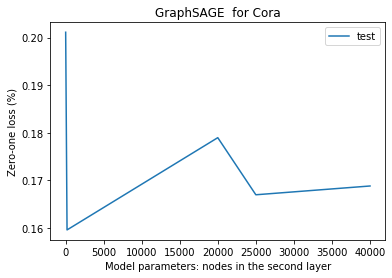

In [43]:
plt.plot([20, 200, 20000, 25000, 40000], [1-five_points[i][1][1][1] for i in range(5)], label = 'test')
plt.axis()
plt.xlabel('Model parameters: nodes in the second layer')
plt.ylabel('Zero-one loss (%)')
plt.title('GraphSAGE  for Cora')
plt.legend();

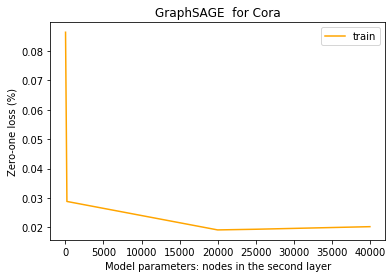

In [46]:
plt.plot([20, 200, 20000, 25000, 40000], [five_points[i][1][0][0] for i in range(5)], label = 'train', c='orange')
plt.axis()
plt.xlabel('Model parameters: nodes in the second layer')
plt.ylabel('Zero-one loss (%)')
plt.title('GraphSAGE  for Cora')
plt.legend();

In [36]:
GraphSAGE_case_study(578840)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
55/55 [==============================] - 9s 162ms/step - loss: 0.5922 - acc: 0.6919
	loss: 0.6073
	acc: 0.6803
	loss: 0.5922
	acc: 0.6919
Epoch 1/20
49/49 - 33s - loss: 0.6837 - acc: 0.6055 - val_loss: 0.5679 - val_acc: 0.6624
Epoch 2/20
49/49 - 32s - loss: 0.4516 - acc: 0.8084 - val_loss: 0.4936 - val_acc: 0.7768
Epoch 3/20
49/49 - 31s - loss: 0.4185 - acc: 0.7982 - val_loss: 0.5034 - val_acc: 0.8303
Epoch 4/20
49/49 - 31s - loss: 0.3055 - acc: 0.9047 - val_loss: 0.4789 - val_acc: 0.8220
Epoch 5/20
49/49 - 31s - loss: 0.2271 - acc: 0.9447 - val_loss: 0.4911 - val_acc: 0.8293
Epoch 6/20
49/49 - 31s - loss: 0.1639 - acc: 0.9662 - val_loss: 0.4831 - val_acc: 0.8349
Epoch 7/20
49/49 - 32s - loss: 0.1471 - acc: 0.9559 - val_loss: 0.5559 - val_acc: 0.8303
Epoch 8/20
49/49 - 31s - loss: 0.1312 - acc: 0.9775 - val_loss: 0.5983 - val_acc: 0.8284
Epoch 9/20
49/49 - 31s - loss: 0.1048 - acc: 0.9805 - val_loss:

([0.020331911742687225, 1.0], [0.6974055171012878, 0.8348708748817444])

In [39]:
GraphSAGE_case_study(700000)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
55/55 [==============================] - 9s 159ms/step - loss: 0.5681 - acc: 0.7426
	loss: 0.6020
	acc: 0.6844
	loss: 0.5681
	acc: 0.7426
Epoch 1/20
49/49 - 34s - loss: 0.6586 - acc: 0.6445 - val_loss: 0.5046 - val_acc: 0.7232
Epoch 2/20
49/49 - 34s - loss: 0.6247 - acc: 0.6885 - val_loss: 1.0416 - val_acc: 0.5009
Epoch 3/20
49/49 - 34s - loss: 0.6328 - acc: 0.6373 - val_loss: 0.4822 - val_acc: 0.7371
Epoch 4/20
49/49 - 33s - loss: 0.4159 - acc: 0.8453 - val_loss: 0.4678 - val_acc: 0.7980
Epoch 5/20
49/49 - 33s - loss: 0.3350 - acc: 0.8689 - val_loss: 0.4687 - val_acc: 0.7851
Epoch 6/20
49/49 - 33s - loss: 0.2793 - acc: 0.8852 - val_loss: 0.4613 - val_acc: 0.8100
Epoch 7/20
49/49 - 33s - loss: 0.2296 - acc: 0.9314 - val_loss: 0.4682 - val_acc: 0.8303
Epoch 8/20
49/49 - 34s - loss: 0.2041 - acc: 0.9395 - val_loss: 0.4788 - val_acc: 0.8330
Epoch 9/20
49/49 - 34s - loss: 0.1694 - acc: 0.9570 - val_loss:

([0.036305345594882965, 1.0], [0.6069465279579163, 0.8348708748817444])

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/graphsage-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>